# CT Managing for Gate Simulation 

## Reading Dicom through VTK

In [1]:
import dicom
import os
import numpy
import vtk
from vtk.util import numpy_support
from matplotlib import pyplot, cm
%pylab inline
from natsort import natsorted
import plotly.offline as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)
from vtk.util import vtkImageImportFromArray as viifa 
import array


Populating the interactive namespace from numpy and matplotlib


### Set the directory path of Dicom CT scann

In [2]:

PathDicom = "CTscanElec"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

### Transform VTK object (CT scan into numpy 3d array)

In [3]:
#Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()

#Get the 'vtkPointData' forom the 'vtkImagedata' object
pointData = imageData.GetPointData()

#Ensure that only one array exist within the 'vtkPoint Data object
assert (pointData.GetNumberOfArrays()==1)

#get the 'vtkArray' (or whatever drived type) which is nedded for  the numpy_support.vtk_to_numpy` function
arrayData=pointData.GetArray(0)

#get the 'vtkArray' to Numpy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)

#Get image dimension
DicomSize=reader.GetOutput().GetDimensions()

#Get pixel dimension
DicompixelSize=reader.GetDataSpacing()

#reshape the Numpy array 3D usin 'DicomSize' as a 'shape'
ArrayDicom = ArrayDicom.reshape(DicomSize, order='F')



print 'Dicom Size :'
print DicomSize
print 'Dicom Pixel Size'
print DicompixelSize

# FLIP ARRAY TO HAVE A DORSAL RECUMBENCY 
arrayDicom=numpy.fliplr(ArrayDicom)
#arrayDicom=ArrayDicom

Dicom Size :
(512, 512, 161)
Dicom Pixel Size
(1.269531011581421, 1.269531011581421, 2.5)


### Write a Raw File of CT scan 

#### Image can be opened with image : 16 bit signed - Little endian byte order

In [4]:
#data = np.zeros((DicomSize), dtype=np.int)
data = arrayDicom.flatten('F')
#print type(data)

#Write Raw File 
filename = 'CT1'
binfile = filename + '.raw'
bitas = array.array('h', data)
print binfile 
with open(binfile, 'wb') as file:
    file.write(bitas)

#Write mhd File
mhdFile = filename + '.mhd'
print mhdFile

with open(mhdFile, 'wt') as file:
    file.write('ObjectType = Image\n')
    file.write('NDims = ' + str(len(DicomSize)) + '\n')
    file.write('BinaryData = True\n')
    file.write('BinaryDataByteOrderMSB = False\n')
    file.write('CompressedData = False\n')
    file.write('TransformMatrix = 1 0 0 0 1 0 0 0 1\n')
    file.write('Offset = 0 0 0\n')
    file.write('CenterOfRotation = 0 0 0\n')
    file.write('ElementSpacing = ' + str(DicompixelSize[0]) +' '+ str(DicompixelSize[1]) +' '+ str(DicompixelSize[2]) +'\n')
    file.write('DimSize = ' + str(DicomSize[0]) +' '+ str(DicomSize[1]) +' '+ str(DicomSize[2]) + '\n')
    file.write('ElementType = MET_SHORT\n')
    file.write('ElementDataFile = ' + binfile)
print DicomSize

CT1.raw
CT1.mhd
(512, 512, 161)


### CROP CT scan for GATE simulation 

#### Image can be opened with image : 16 bit signed - Little endian byte order

In [9]:
# Get index for cropping based on CT scan

#Create a sum of each slice of CT scan
SuM_CT=numpy.zeros((DicomSize[0], DicomSize[1]))
for k in range(0, DicomSize[2]):
    SuM_CT = SuM_CT + arrayDicom[: ,: , k]

#create meanvalue for Row (512, meanA) and for Column (512, meanB) 
meanA=numpy.mean(SuM_CT, axis=0)
meanB=numpy.mean(SuM_CT, axis=1)


#Define a threshlod 35% of the max HU for y index 56% of the HU for x index
thresholdA = max(meanA)/0.35
thresholdB = max(meanB)/0.56
#print thresholdA
#print thresholdB

for i in range(0, len(meanA)):
    if meanA[i]>thresholdA:
        y1_crop=i-20  #ventre
        #print y1_crop
        break

for i in range(len(meanA)-1, -1, -1):
    if meanA[i]>thresholdA:
        y2_croptemp=i-60  # suppression d'une partie de la table 
        break

for i in range(0, len(meanB)):
    if meanB[i]>thresholdB:
        x1_crop=i-20  #gauche de l'image
        break
        
for i in range(len(meanB)-1, -1, -1):
    if meanB[i]>thresholdB:
        x2_croptemp=i+20  #droite de l'image
        break
        

#plot with plotly
x1 = numpy.arange(0, len(meanA))
x2 =  numpy.arange(0, len(meanB))

trace1 = go.Scatter(
    x = x1,
    y = meanA,
    mode = 'lines', 
    name = 'meanA = Proil du scan cumulé en Y')

trace2 = go.Scatter(
    x = x2,
    y = meanB,
    mode = 'lines', 
    name = 'meanB = Profil du scan cumulé en X')

data = [trace1, trace2]
py.iplot(data, filename='scatter-mode')

x2_crop=x2_croptemp-DicomSize[0]
y2_crop=y2_croptemp-DicomSize[1]


# crope numpy array of CT scann with array slicing [du iéme pixelà partir de la gauche:au iéme pixel à partir de ladroit, du iéme pixel à partir du haut:au iéme pixel à partir du bas]
crop_img=arrayDicom[x1_crop:x2_crop, y1_crop:y2_crop]
#print crop_img.shape

#Write raw file of copped CT scann 

datacrop = crop_img.flatten('F')

filename = 'CT_crop1'
binfile = filename + '.raw'
bitas = array.array('h', datacrop)
print binfile 
with open(binfile, 'wb') as file:
    file.write(bitas)

mhdFile = filename + '.mhd'
print mhdFile

with open(mhdFile, 'wt') as file:
    file.write('ObjectType = Image\n')
    file.write('NDims = ' + str(len(crop_img.shape)) + '\n')
    file.write('BinaryData = True\n')
    file.write('BinaryDataByteOrderMSB = False\n')
    file.write('CompressedData = False\n')
    file.write('TransformMatrix = 1 0 0 0 1 0 0 0 1\n')
    file.write('Offset = 0 0 0\n')
    file.write('CenterOfRotation = 0 0 0\n')
    file.write('ElementSpacing = ' + str(DicompixelSize[0]) +' '+ str(DicompixelSize[1]) +' '+ str(DicompixelSize[2]) +'\n')
    file.write('DimSize = ' + str(crop_img.shape[0]) +' '+ str(crop_img.shape[1]) +' '+ str(crop_img.shape[2]) + '\n')
    file.write('ElementType = MET_SHORT\n')
    file.write('ElementDataFile = ' + binfile)
print crop_img.shape

-261928.526786
-205167.647879
-20


CT_crop1.raw
CT_crop1.mhd
(0, 0, 161)


### Print a slice of CT scan 

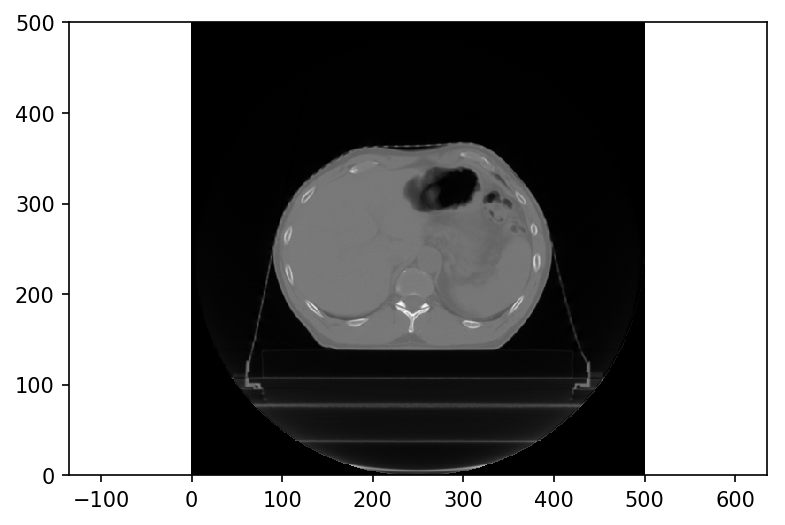

In [53]:
#User DicomSize and DicomPixelSize to create axes for this array

#Create axis 
x = numpy.arange(0.0,(DicomSize[0]+1)*DicompixelSize[0], DicompixelSize[0])
y = numpy.arange(0.0, (DicomSize[1]+1)*DicompixelSize[1], DicompixelSize[1])
z = numpy.arange(0.0, (DicomSize[2]+1)*DicompixelSize[2], DicompixelSize[2])


#
pyplot.figure(dpi=150)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, rot90(arrayDicom[:, :, 110]))